# Two component Universe: Choice of equations

The equations for perturbations are not independent, so one can chose any of the Einstein equations to get the solutions. Here we will try to understand the relation in more detail.

**Warning** this is clearly a very hard problem. You can safely skip it, as many seasoned researchers working in the area do, but if you manage to solve it, you'll learn a lot about differential equations, Einstein equations, numerical mysteries.

In these notebook you will find the numerical solutions for the evolution of perturbations in a Universe filled with radiation and non-relativistic matter, solved using the energy momentum conservation equations and two different Einsein equations - either *'00'* or *'0i'* component. In both cases the initial conditions used were the lower order in $\eta$ adiabatic initial conditions. The mode was choen to enter the horion at matter domination (MD). You can see in the plots in the notebook, that the solutions are very different: the Newton potential $\Phi$ decreases to $9/10\Phi_{(i)}$ in one case (correct result), while _increases_ if another set of equations is used. At the same time it is expected that any of the Einstein equations should lead to the sae correct answer.

Can you spot what is the problem? *Hint:* look very carefully at the initial conditions using *all* the equations.

In [1]:
from numpy import pi, sqrt
import numpy as np

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats={'retina','png'}

from numba import jit

Define the equations.  Convention is that the vector of unknows `y[0:5]` contains $(a, \Phi, \delta_m, v_m, \delta_r, v_r)$.

By convention $a_0=1$ in the code.

Verison 1 of the equations: the Poisson equation (00) for gravity perturbations, and conservationequations:
$$\begin{align}
  -k^2{\Phi}-3\frac{a'}{a}{\Phi}'-3\frac{{a'}^2}{a^2}{\Phi}
    &= 4\pi Ga^2\left[ \rho_{{\mathrm{m}}}{\delta}_{{\mathrm{m}}}+\rho_{{\mathrm{r}}}{\delta}_{{\mathrm{r}}} \right],  \label{eq:pert2c1} \\
{\delta}_{{\mathrm{m}}}' - k^2v_{{\mathrm{m}}}                     &= 3{\Phi}',  \label{eq:pert2c2} \\
  v_{{\mathrm{m}}}' + \frac{a'}{a}v_{{\mathrm{m}}}                 &= -{\Phi}.   \label{eq:pert2c3} \\
  {\delta}_{{\mathrm{r}}}'-\frac{4}{3}k^2v_{{\mathrm{r}}}            &= 4{\Phi}',  \label{eq:pert2c4} \\
  v_{{\mathrm{r}}}' + \frac{1}{4}{\delta}_{{\mathrm{r}}}             &= -{\Phi}.   \label{eq:pert2c5}
\end{align}
$$
with $4\pi G a^2\rho_m=\frac{3}{2}H_0^2\Omega_m\frac{a_0^3}{a}$, $4\pi G a^2\rho_r=\frac{3}{2}H_0^2\Omega_r\frac{a_0^4}{a^2}$

Also, the Friedman equation for scale factor is used to get the exact background expansion
$$
a'/a = a H \equiv a H_0 \sqrt{\Omega_m\left(\frac{a_0}{a}\right)^3+\Omega_r\left(\frac{a_0}{a}\right)^4}
$$

In [2]:
@jit
def eqns1(tau, Y, H0, OM, Or, k):
    a, Phi, dm, vm, dr, vr = Y
    Ha = a*H0*sqrt(OM/a**3+Or/a**4)
    k2 = k*k
    da = Ha*a
    dPhi = -(3/2*H0*H0*(dm*OM/a+dr*Or/(a*a))+(k2+3*Ha*Ha)*Phi)/3/Ha
    ddm = 3*dPhi+k2*vm
    dvm = -Phi-Ha*vm
    ddr = 4*dPhi+4/3*k2*vr
    dvr = -Phi-dr/4
    return np.array((da, dPhi, ddm, dvm, ddr, dvr))

Verison 2 of the equations: the (_0i_) equation for gravity perturbations, and conservationequations:
$$\begin{align}
  {\Phi}' + \frac{a'}{a}{\Phi}
    &= -4\pi Ga^2 (\rho_mv_m + \frac{4}{3}\rho_rv_r),
  \notag\\
{\delta}_{{\mathrm{m}}}' - k^2v_{{\mathrm{m}}}                     &= 3{\Phi}',  \label{eq:pert2c2} \\
  v_{{\mathrm{m}}}' + \frac{a'}{a}v_{{\mathrm{m}}}                 &= -{\Phi}.   \label{eq:pert2c3} \\
  {\delta}_{{\mathrm{r}}}'-\frac{4}{3}k^2v_{{\mathrm{r}}}            &= 4{\Phi}',  \label{eq:pert2c4} \\
  v_{{\mathrm{r}}}' + \frac{1}{4}{\delta}_{{\mathrm{r}}}             &= -{\Phi}.   \label{eq:pert2c5}
\end{align}
$$

In [3]:
@jit
def eqns2(tau, Y, H0, OM, Or, k):
    a, Phi, dm, vm, dr, vr = Y
    Ha = a*H0*sqrt(OM/a**3+Or/a**4)
    k2 = k*k
    da = Ha*a
    dPhi = -Ha*Phi-(3/2*H0*H0*a*a*(OM/a**3*vm+4/3*Or/a**4*vr))
    ddm = 3*dPhi+k2*vm
    dvm = -Phi-Ha*vm
    ddr = 4*dPhi+4/3*k2*vr
    dvr = -Phi-dr/4
    return np.array((da, dPhi, ddm, dvm, ddr, dvr))

These are adiabatic initial condition to the lowest order in $\eta$
$$
\begin{align}
{\delta}_{m}=\frac{3}{4}{\delta}_r=
    -\frac{3}{2}{\Phi}&=1,\\
    v_{m}=v_r=\frac{1}{3}{\eta}
\end{align}
$$
And early time scale factor
$$
a = H_0\sqrt{\Omega_r}\eta
$$
(we neglect the change of the number of degrees of freedom for simplicity)

In [4]:
def adiabatic_ic(eta,k):    
    a = H0*eta*sqrt(Or)
    Phi = -2/3
    dm = -3/2*Phi
    dr = -2*Phi
    vm = -Phi/2*eta
    vr = -Phi/2*eta
    return np.array((a, Phi, dm, vm, dr, vr))

These are the service functions that solve the differential equations from eta1 to eta2

In [5]:
def solve(eta1, eta2, ic):
    return solve_ivp(eqns1, (eta1, eta2), ic, args=(H0, OM, Or, k), rtol=1e-8, atol=1e-10)

In [6]:
def solve2(eta1, eta2, ic):
    return solve_ivp(eqns2, (eta1, eta2), ic, args=(H0, OM, Or, k), rtol=1e-8, atol=1e-10)

## Mode entering at MD

Let us define the Universe with 'reasonably realistic' parameters — a small amount of radiation today, and select the mode _k_ that enters horizon at MD

In [7]:
k=0.0008

H0=0.7*100*3.33564e-6 # 1/Mpc
Or=1e-4
OM=1-Or

Let us solve the two versions of the equations

In [8]:
eta1 = 1
eta2 = 18000
res = solve(eta1, eta2, adiabatic_ic(eta1,k))
res2 = solve2(eta1, eta2, adiabatic_ic(eta1,k))

You may safely ignore this -- numerically find the RD/MD equality and crossing moments of time, used only for illustration later

In [9]:
eta_at_rho_m_over_r = interp1d(OM/(Or/res.y[0,:]),res.t)
eta_at_crossing = interp1d(H0*np.sqrt(OM/res.y[0,:]**3+Or/res.y[0,:]**4)/(k/res.y[0,:]), res.t)
eta_eq = eta_at_rho_m_over_r(1.)
eta_x = eta_at_crossing(1.)

So, why the two solutions do not coincide?!

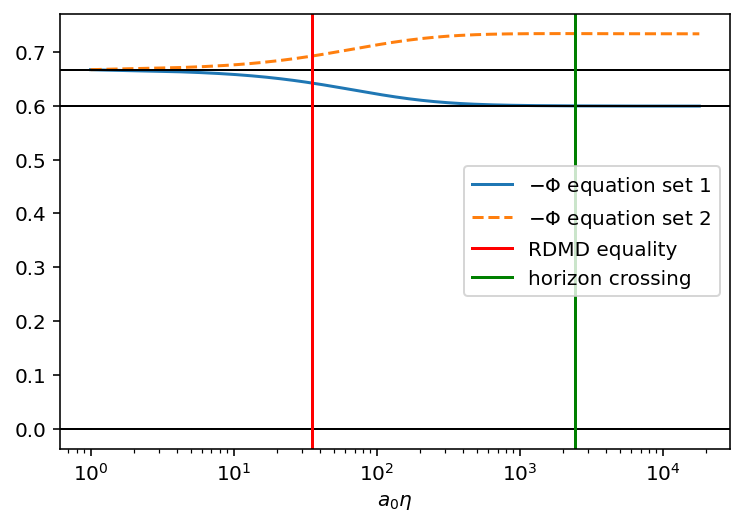

In [10]:
plt.semilogx(res.t,-res.y[1,:], label=r"$-\Phi$ equation set 1")
plt.semilogx(res2.t,-res2.y[1,:], '--', label=r"$-\Phi$ equation set 2")

plt.axhline(0, color='black', lw=1)
plt.axhline(2/3, color='black', lw=1)
plt.axhline(2/3*9/10, color='black', lw=1)
plt.axvline(eta_eq, color='red', label="RDMD equality")
plt.axvline(eta_x, color="green", label="horizon crossing")
plt.xlabel(r"$a_0\eta$")
plt.legend()

This one is a log-log plot just to reassure you that teh matter perturbations grow after the horizon crossing (while the Newton potanital form the last plot does not really change after the horizon crossing).

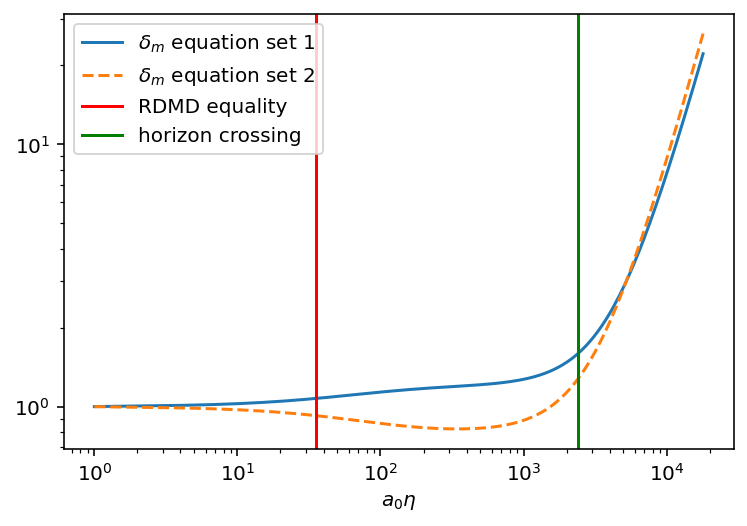

In [11]:
plt.loglog(res.t,res.y[2,:], label=r"$\delta_m$ equation set 1")
plt.loglog(res2.t,res2.y[2,:], '--', label=r"$\delta_m$ equation set 2")

plt.axhline(0, color='black', lw=1)
plt.axvline(eta_eq, color='red', label="RDMD equality")
plt.axvline(eta_x, color="green", label="horizon crossing")
plt.xlabel(r"$a_0\eta$")
plt.legend()